# Spatial feature engineering

Ways to "stick" space into models that are not necessarily spatial.

**spatial feature engineering**: synthesizing information using spatial relationships either within the data or across data. 

This is one way of "spatializing" data that is included in models. This is not about fitting *spatial models* that use
> the kohonen quote about spatially-correlated learning in SOMs

it is about figuring out representations of geographical relationships and using them in typical non-spatial models. 



Geographying

Spatializing

*(note: fit the distinction between using spatialized data vs. using spatial models into the regression chapter, ch. 11)*. 

## Feature Engineering Using Map Matching
*Using spatial relationships between two datasets to transfer information from one to another for a model.*
"Space is the ultimate linkage key." - DAB
### start by doing counting features on distanceband weights

In [88]:
import geopandas, pandas, libpysal.weights as weights, contextily
import matplotlib.pyplot as plt
import numpy
import osmnx
import rasterio

In [6]:
airbnbs = geopandas.read_file('../data/airbnb/regression_db.geojson')

In [215]:
basemap, basemap_ext = contextily.bounds2img(*airbnbs.to_crs(epsg=3857).total_bounds,
                                 zoom=10,
                                 url=contextily.tile_providers.ST_TONER)

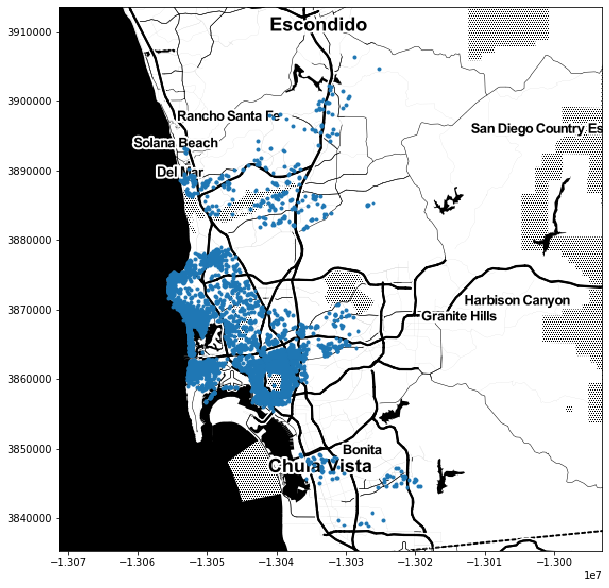

In [216]:
f,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(basemap, extent=basemap_ext)
airbnbs.to_crs(epsg=3857).plot(ax=ax, marker='.')

In [42]:
pois = osmnx.pois_from_polygon(airbnbs.unary_union.convex_hull,
                               amenities=['restaurant', 'bar'])
pois = pois.query('amenity in ("restaurant", "bar")')

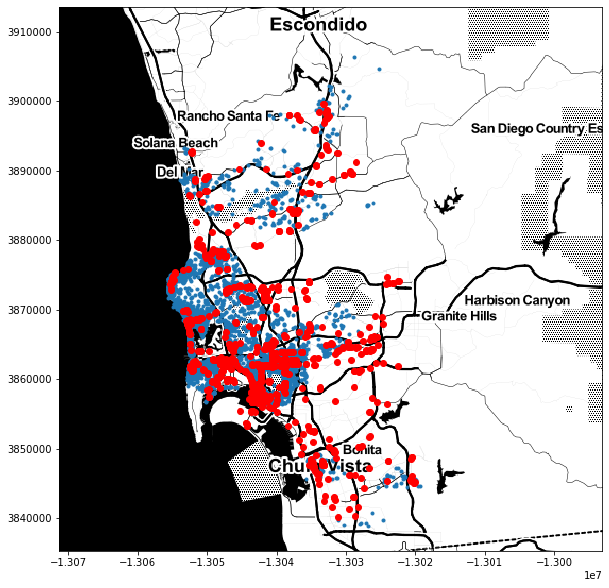

In [43]:
f,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(img, extent=ext)
airbnbs.to_crs(epsg=3857).plot(ax=ax, marker='.')
pois.to_crs(epsg=3857).plot(ax=ax, color='r')

In [190]:
pois_per_listing = geopandas.sjoin(airbnbs.set_geometry(airbnbs.buffer(.01)), 
                                   pois, op='intersects').groupby('id').id.count()

/home/lw17329/anaconda3/envs/ana/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(epsg:4326 != +proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs +type=crs)
  "(%s != %s)" % (left_df.crs, right_df.crs)


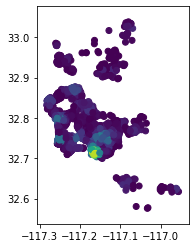

In [191]:
airbnbs.merge(pois_per_listing.to_frame('n_pois'), left_on='id', right_index=True).plot('n_pois')

# DEM sampling for a regression covariate


### distance banding counts & distance-to a secondary feature
- osmnx pois
- flicker data

### Point Interpolation using sklearn 
- (streetscore averaging from nearest sites)
- air quality?

### spatial join, but really don't focus too much on the structure/GIS theory of it
- census data 

### tobler? area to area interpolation

- census geographies vs. h3

### raster engineering to vector features

- Elevation: https://blog.mapbox.com/global-elevation-data-6689f1d0ba65
- DEM from USGS? Public domain? https://www.usgs.gov/centers/eros/science/usgs-eros-archive-digital-elevation-shuttle-radar-topography-mission-srtm-1-arc?qt-science_center_objects=0#qt-science_center_objects
- air quality
- night light - served through nasa, using - contextily

In [203]:
mapbox_access_token = ""
demraw, demext = contextily.bounds2img(*airbnbs.to_crs(epsg=3857).total_bounds, zoom=11,
                                       url='https://api.mapbox.com/v4/mapbox.terrain-rgb/'
                                           '{z}/{x}/{y}.pngraw?access_token='+mapbox_access_token) 

In [204]:
demraw = demraw.astype(numpy.uint64)

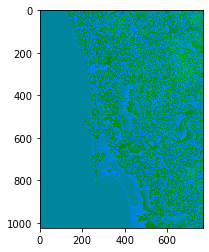

In [221]:
plt.imshow(demraw)

In [205]:
h,w,b = demraw.shape

In [206]:
dem = -1e4 + (demraw[:,:,0]*256**2 + 
              demraw[:,:,1]*256 + 
              demraw[:,:,2])*.1

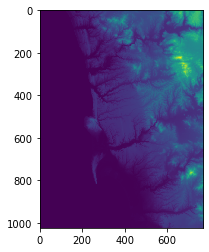

In [225]:
plt.imshow(dem)

In [226]:
airbnbs_webmerc_coords = numpy.column_stack((airbnbs.to_crs(epsg=3857).geometry.x, 
                                             airbnbs.to_crs(epsg=3857).geometry.y))

In [227]:
dembounds = (demext[0], demext[2], demext[1], demext[3])

In [228]:
transform = rasterio.transform.from_bounds(*dembounds, w,h)

In [229]:
with rasterio.MemoryFile() as vfile:
    with vfile.open(driver='GTiff', height=h, width=w, count=1, 
                    dtype=dem.dtype, 
                    crs='epsg:3857', transform=transform) as dem_tmp:
        dem_tmp.write(dem, 1)
        elevation_generator = dem_tmp.sample(airbnbs_webmerc_coords)
        elevation_at_airbnb = numpy.row_stack(list(elevation_generator))

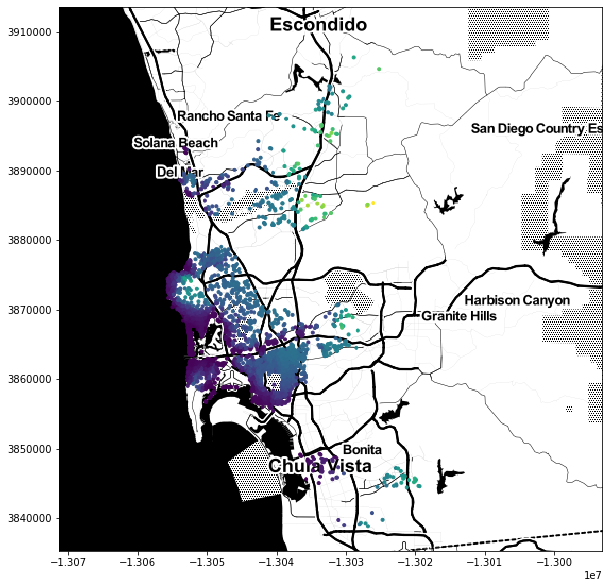

In [230]:
f,ax = plt.subplots(1,1,figsize=(10,10))
ax = airbnbs.assign(elev = elevation_at_airbnb)\
            .to_crs(epsg=3857).plot('elev', marker='.',ax=ax)
ax.imshow(basemap, extent=basemap_ext)

## Feature Engineering using Map Synthesis
*Using spatial relationships within a single dataset to synthesize new features for a model.*
### generalize distanceband/buffer counting into a re-explanation of WX models under different weights
### KNN-engineering, adding features by distances
### distance-banding
### eigenvectors feature engineering
### preclustering points into groups for group-based regressions
### use spatially-constrained clustering to build categorical variables for regression

---

<a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-nd/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License</a>.